In [1]:
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
import pandas as pd
import importlib

In [2]:
from sklearn.model_selection import train_test_split

%config InlineBackend.figure_format = "retina"

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.5.0


In [4]:
RANDOM_SEED = 5781
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [5]:
lung = pd.read_csv("lung.csv")
lung

,Unnamed: 0,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
0,1,3.0,306,2,74,1,1.0,90.0,100.0,1175.0,NaN
1,2,3.0,455,2,68,1,0.0,90.0,90.0,1225.0,15.0
2,3,3.0,1010,1,56,1,0.0,90.0,90.0,NaN,15.0
3,4,5.0,210,2,57,1,1.0,90.0,60.0,1150.0,11.0
4,5,1.0,883,2,60,1,0.0,100.0,90.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...
223,224,1.0,188,1,77,1,1.0,80.0,60.0,NaN,3.0
224,225,13.0,191,1,39,1,0.0,90.0,90.0,2350.0,-5.0
225,226,32.0,105,1,75,2,2.0,60.0,70.0,1025.0,5.0
226,227,6.0,174,1,66,1,1.0,90.0,100.0,1075.0,1.0


In [6]:
N = len(lung)

lung["ph.karno"] = lung["ph.karno"].fillna(lung["pat.karno"])


In [7]:
times = np.array(np.ceil(lung["time"]/30))
delta = np.array(lung["status"] - 1)


In [8]:
x_train = lung[["age", "sex", "ph.karno"]].copy()

In [9]:
x_train

,age,sex,ph.karno
0,74,1,90.0
1,68,1,90.0
2,56,1,90.0
3,57,1,90.0
4,60,1,100.0
...,...,...,...
223,77,1,80.0
224,39,1,90.0
225,75,2,60.0
226,66,1,90.0


In [10]:
def get_long_timseries(times, events, x_train):
    tm = list(set(times))
    tm.sort()
    dct_tm = dict(zip(tm, range(1,len(tm)+1)))
    dct_tm[0] = 0
    tm_list = list(dct_tm.keys())
    pat_c = 1

    events_new = []
    times_new = []
    x_new = []
    pat_new = []
    for i in range(0, len(times)):
        # get number of times
        tv = dct_tm[times[i]] 
        # create empty time array to size tv
        tmp_t = np.zeros(tv)
        # set last time index of tmp_t to event indicator
        tmp_t[-1] = delta[i]
        # get subset of of time keys of size tv
        tmp_times = tm[0:tv]

        # get expanded set of x values of size tv
        tmp_x = [x_train.loc[i,:].values.tolist(),] * tv
        # get expanded set of pat indicator of size tv
        tmp_pat = [pat_c] * tv
        pat_c = pat_c + 1
        
        events_new.append(tmp_t)
        times_new.append(tmp_times)
        x_new.append(tmp_x)
        pat_new.append(tmp_pat)

    # unnest lists 
    x_new = [tuple(i) for j in x_new for i in j]
    times_new = [u for t in times_new for u in t]
    events_new = [u for t in events_new for u in t]
    pat_new = [p for pat in pat_new for p in pat]

    # create df
    out = pd.DataFrame(x_new, columns=["age", "sex", "ph.karno"])
    out["times"] = times_new
    out["events"] = events_new
    out["pat"] = pat_new
    return out

In [11]:
data_cln = get_long_timseries(times, delta, x_train)

In [12]:
data_cln

,age,sex,ph.karno,times,events,pat
0,74.0,1.0,90.0,1.0,0.0,1
1,74.0,1.0,90.0,2.0,0.0,1
2,74.0,1.0,90.0,3.0,0.0,1
3,74.0,1.0,90.0,4.0,0.0,1
4,74.0,1.0,90.0,5.0,0.0,1
...,...,...,...,...,...,...
2373,58.0,2.0,80.0,2.0,0.0,228
2374,58.0,2.0,80.0,3.0,0.0,228
2375,58.0,2.0,80.0,4.0,0.0,228
2376,58.0,2.0,80.0,5.0,0.0,228


gbart steps

In [13]:
# seperate data
x_ = data_cln[["times", "age", "sex", "ph.karno"]]
y_ = data_cln["events"]

In [14]:
with pm.Model() as lung:
    mu_ = pmb.BART("mu_", X=x_, Y=y_, m=20)
    mu = pm.Deterministic("mu", pm.math.invprobit(mu_))
    y_pred = pm.Bernoulli("y_pred", p=mu, observed=y_)
    lung_smp = pm.sample(random_seed=2)
    # lung_pp = pm.sample_posterior_predictive(lung_smp, random_seed=2)

Multiprocess sampling (4 chains in 4 jobs)
PGBART: [mu_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
/home/twj8/.local/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


lung_smp

In [15]:
lung_smp

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [17]:
post = data_cln.copy()

In [463]:
lung_smp

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [18]:
post["post1"] = np.mean(lung_smp.posterior.mu[0],axis=0)
post["post2"] = np.mean(lung_smp.posterior.mu[1],axis=0)
post["post3"] = np.mean(lung_smp.posterior.mu[2],axis=0)
post["post4"] = np.mean(lung_smp.posterior.mu[3],axis=0)

In [19]:
def surv_fnc(dtst, var):
    vars = "inv" + var
    dtst["inv_" + var] = 1-dtst[var]
    dtst["surv_"+var] = dtst.groupby("pat")["inv_"+var].cumprod()
    return dtst

In [20]:
post2 = surv_fnc(post, "post1")

In [21]:
post2

,age,sex,ph.karno,times,events,pat,post1,post2,post3,post4,inv_post1,surv_post1
0,74.0,1.0,90.0,1.0,0.0,1,0.057788,0.054712,0.057090,0.061511,0.942212,0.942212
1,74.0,1.0,90.0,2.0,0.0,1,0.059205,0.058047,0.058076,0.060870,0.940795,0.886428
2,74.0,1.0,90.0,3.0,0.0,1,0.061284,0.060537,0.061227,0.063864,0.938716,0.832104
3,74.0,1.0,90.0,4.0,0.0,1,0.064421,0.065147,0.064677,0.069238,0.935579,0.778499
4,74.0,1.0,90.0,5.0,0.0,1,0.073424,0.071489,0.073708,0.074342,0.926576,0.721338
...,...,...,...,...,...,...,...,...,...,...,...,...
2373,58.0,2.0,80.0,2.0,0.0,228,0.041312,0.038916,0.040901,0.040631,0.958688,0.920275
2374,58.0,2.0,80.0,3.0,0.0,228,0.042797,0.040669,0.043306,0.043090,0.957203,0.880890
2375,58.0,2.0,80.0,4.0,0.0,228,0.045164,0.044139,0.045831,0.046643,0.954836,0.841105
2376,58.0,2.0,80.0,5.0,0.0,228,0.051785,0.048808,0.052966,0.050088,0.948215,0.797549


In [22]:
sum_x = post2.groupby("times").mean()
sum_x["times"] = sum_x.index

In [478]:
sum_x

,age,sex,ph.karno,events,pat,post1,post2,post3,post4,inv_post1,surv_post1,times
times,,,,,,,,,,,,
1.0,62.447368,1.394737,81.938326,0.043860,114.500000,0.050603,0.050862,0.049718,0.052370,0.949397,0.949397,1.0
2.0,62.027523,1.408257,82.027650,0.032110,115.545872,0.049867,0.048589,0.051009,0.054768,0.950133,0.902698,2.0
3.0,61.786730,1.417062,82.142857,0.047393,115.800948,0.053988,0.053717,0.055276,0.058103,0.946012,0.854890,3.0
4.0,61.880597,1.417910,82.300000,0.049751,117.447761,0.058254,0.057043,0.057456,0.061406,0.941746,0.805829,4.0
5.0,61.634921,1.423280,83.121693,0.052910,116.873016,0.063955,0.066016,0.063299,0.064880,0.936045,0.756540,5.0
6.0,61.877095,1.430168,83.296089,0.089385,117.525140,0.071173,0.072331,0.070464,0.072406,0.928827,0.704416,6.0
7.0,61.773585,1.446541,84.025157,0.094340,117.358491,0.071744,0.074240,0.076009,0.074653,0.928256,0.658721,7.0
8.0,62.110294,1.448529,84.264706,0.066176,111.191176,0.075669,0.075338,0.077074,0.076771,0.924331,0.611335,8.0
9.0,62.076271,1.466102,84.745763,0.050847,104.525424,0.076094,0.077122,0.078018,0.076415,0.923906,0.570505,9.0


In [24]:
sum_x

,age,sex,ph.karno,events,pat,post1,post2,post3,post4,inv_post1,surv_post1,times
times,,,,,,,,,,,,
1.0,62.447368,1.394737,81.885965,0.043860,114.500000,0.053502,0.050999,0.053661,0.055560,0.946498,0.946498,1.0
2.0,62.027523,1.408257,81.972477,0.032110,115.545872,0.054327,0.053059,0.054098,0.054519,0.945673,0.895715,2.0
3.0,61.786730,1.417062,82.085308,0.047393,115.800948,0.055962,0.054944,0.056801,0.057150,0.944038,0.846512,3.0
4.0,61.880597,1.417910,82.238806,0.049751,117.447761,0.058783,0.059238,0.059788,0.061749,0.941217,0.797563,4.0
5.0,61.634921,1.423280,83.121693,0.052910,116.873016,0.066321,0.064159,0.067505,0.065584,0.933679,0.747318,5.0
6.0,61.877095,1.430168,83.296089,0.089385,117.525140,0.069963,0.070925,0.071718,0.069115,0.930037,0.697041,6.0
7.0,61.773585,1.446541,84.025157,0.094340,117.358491,0.072439,0.074071,0.074478,0.073915,0.927561,0.651811,7.0
8.0,62.110294,1.448529,84.264706,0.066176,111.191176,0.073502,0.077229,0.076842,0.074915,0.926498,0.607143,8.0
9.0,62.076271,1.466102,84.745763,0.050847,104.525424,0.076046,0.078488,0.076800,0.074822,0.923954,0.567180,9.0


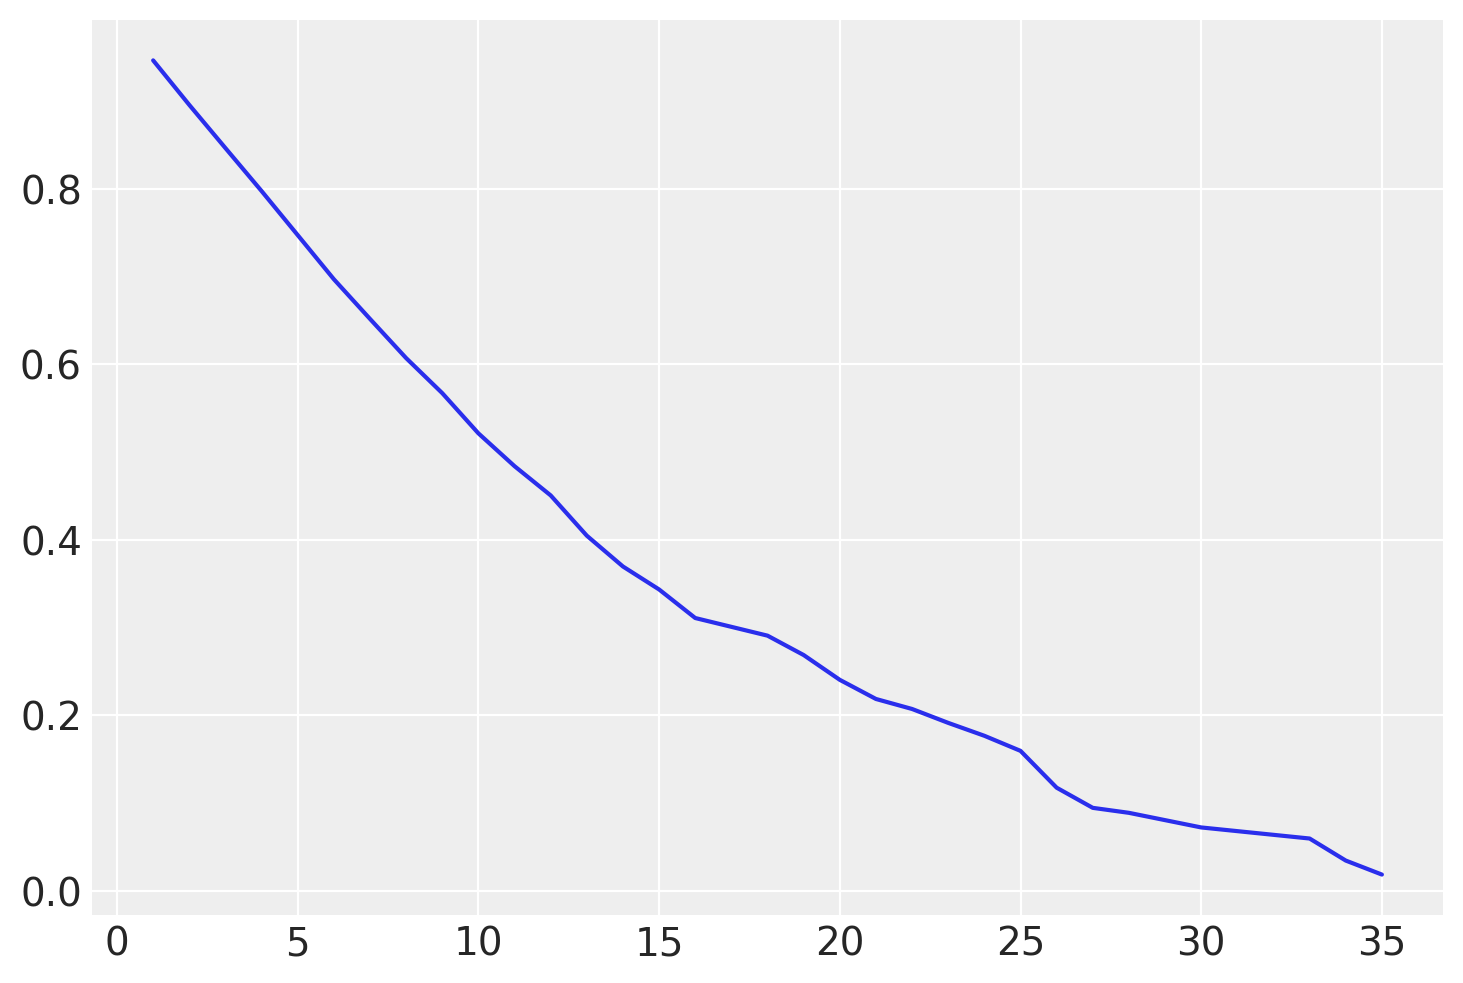

In [23]:
plt.plot(sum_x["times"], sum_x["surv_post1"] )

# CoxPH

In [27]:
import lifelines as ll

<AxesSubplot:xlabel='timeline'>

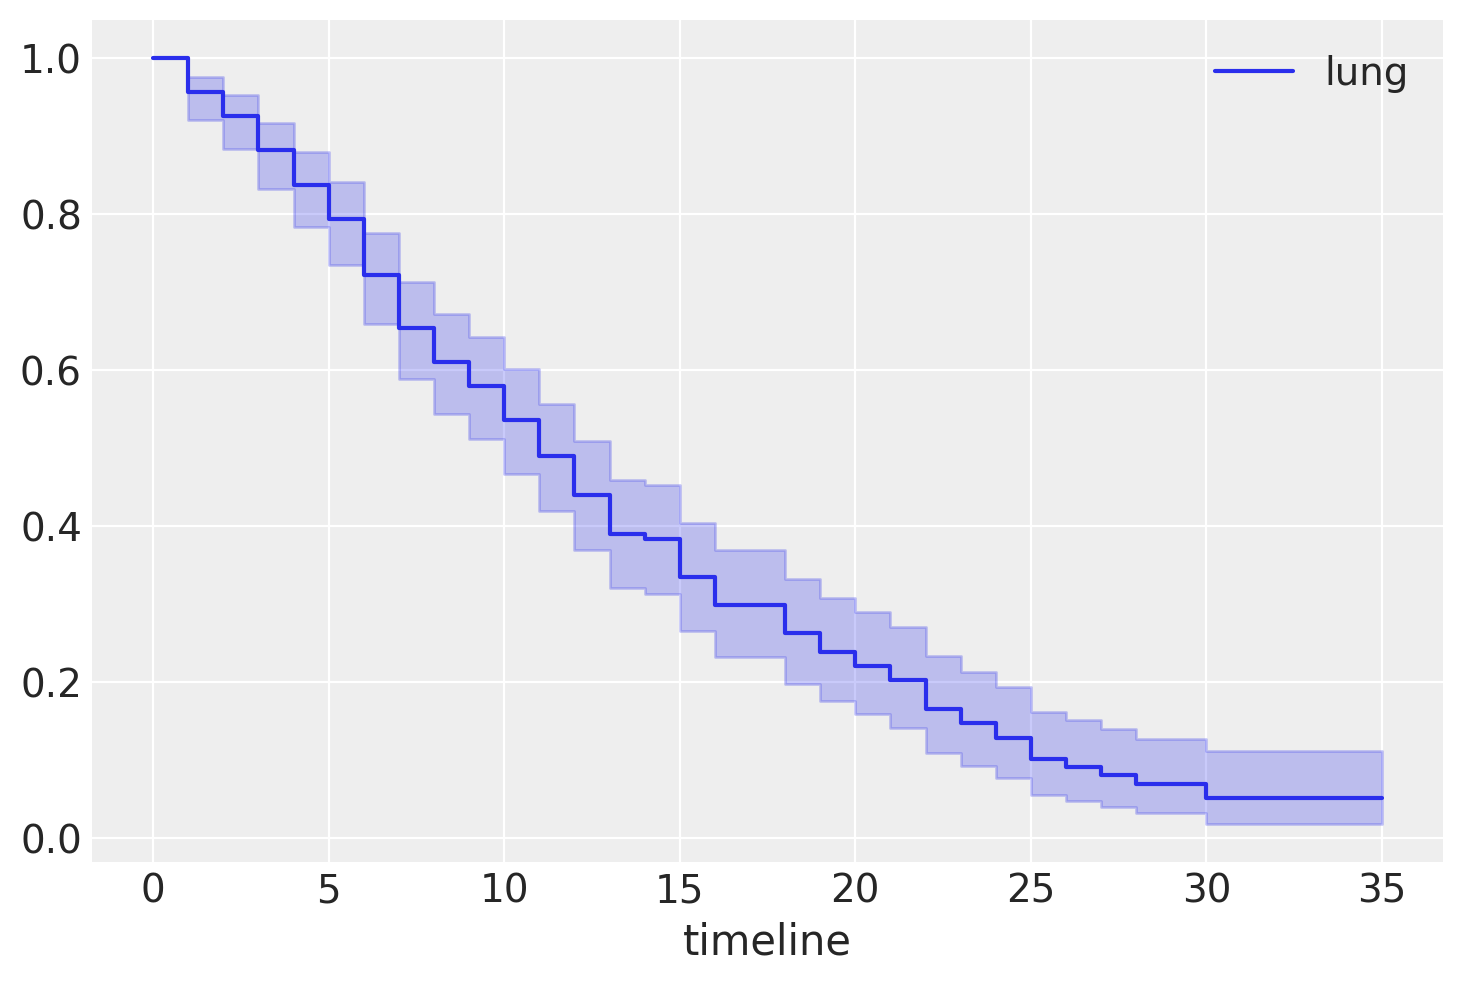

In [33]:
kmf = ll.KaplanMeierFitter(label="lung")
kmf.fit(times, delta)
kmf.plot()

In [44]:
lung_cpg = pd.concat([pd.DataFrame({"times":times, "event":delta}), x_train], axis=1)

cph = ll.CoxPHFitter()
cph.fit(lung_cpg, "times", "event")

cph.print_summary()

# ll.datasets.load_rossi()

<lifelines.CoxPHFitter: fitted with 228 total observations, 63 right-censored observations>
             duration col = 'times'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 228
number of events observed = 165
   partial log-likelihood = -742.21
         time fit was run = 2023-07-17 21:05:44 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age         0.01       1.01       0.01            -0.01             0.03                 0.99                 1.03
sex        -0.52       0.60       0.17            -0.85            -0.19                 0.43                 0.83
ph.karno   -0.01       0.99       0.01            -0.03            -0.00                 0.97                 1.00

            cmp to     z      p   -log2(p)
covariate                                 
age           0.00  1.30   0.19       2.36
sex           0.00 -3.10 <0.005       8.99
ph.karno      0.00 -2.38   0.02       5.84
---
Concordance = 0.65
Partial AIC = 1490.42
log-likelihood ratio test = 20.27 on 3 df
-log2(p) of ll-ratio test = 12.71